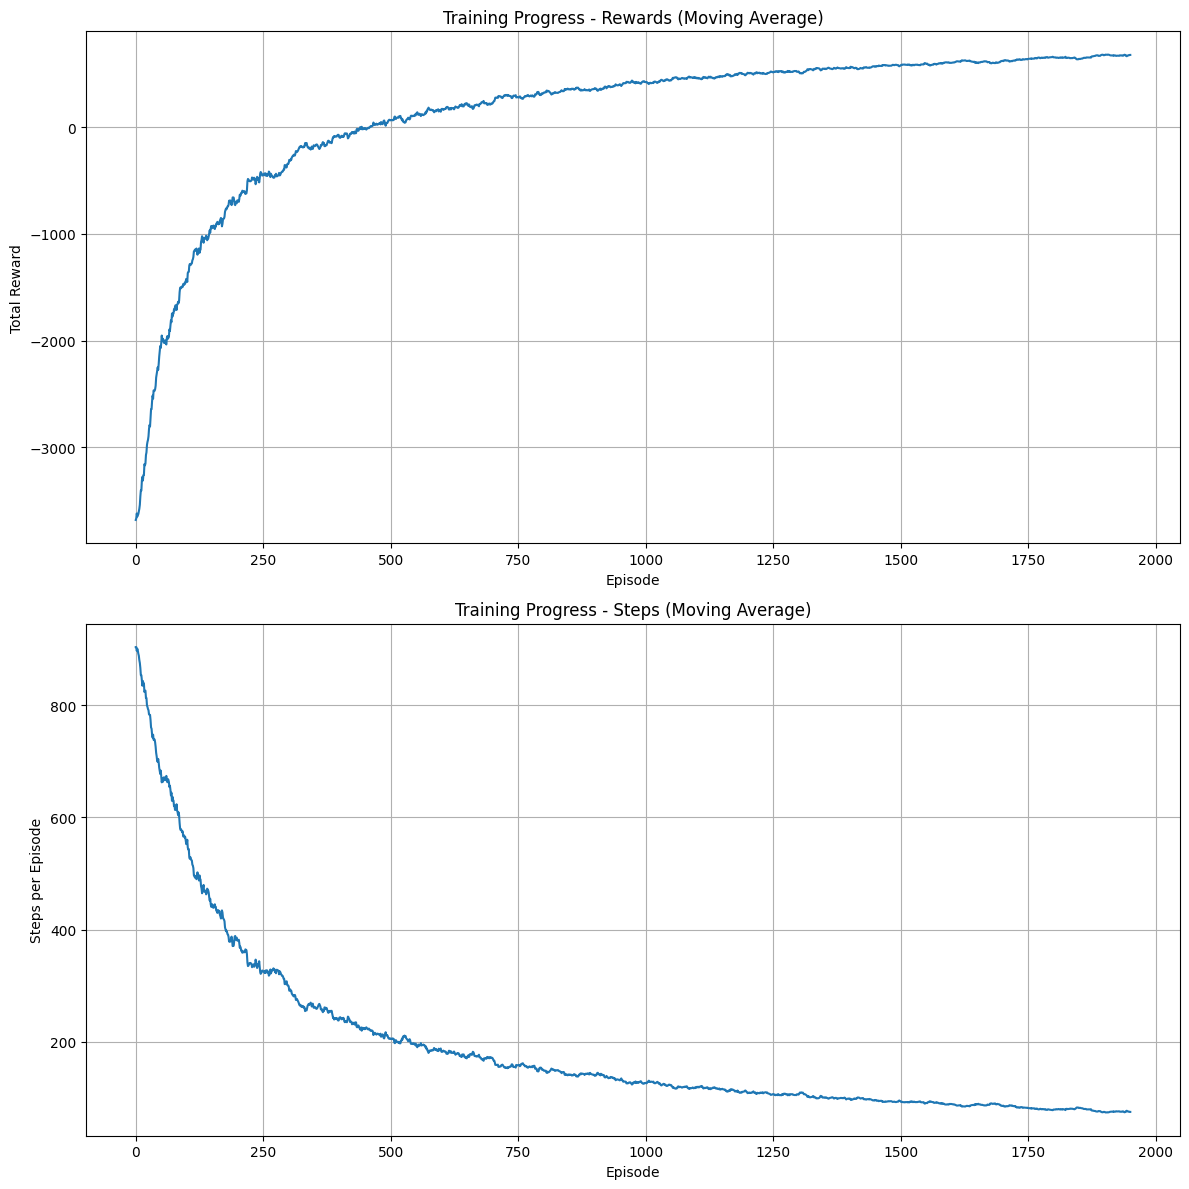


Learned Policy and Path:
Best path length: 63 steps

Chunk (0,0) to (15,15):
0 → → → X → ↓ ↑ ← ← X ↑ → ↓ ↓ ↓
1 2 3 4 5 X ↓ X ↑ ← ↓ ← X ↓ ↓ →
↓ ↑ ↓ → 6 7 ↓ ← ↓ ↓ ↑ ← ← ← X ↓
X ↓ ↓ → → 8 9 0 ↓ ← X ↓ ↓ ↑ X →
→ ↓ X ← → → → 1 X ↓ → → → X ← ↑
↓ → ↓ X → → ↑ 2 → ↓ ↓ → ↓ → → X
↓ ↓ ↑ X → X X 3 → ↓ ↓ → ↓ → → X
→ X → ↓ ↓ ← ↓ 4 → X → ↓ → → → X
← ↓ ← → → ↓ ↓ 5 6 7 8 9 0 ↓ ↓ ↓
→ → → → ↑ → → ↓ → → ← → 1 2 ↓ ↓
X ← ↑ → ↓ ↓ ↓ ↓ → → → → ↓ 3 → X
→ ↑ ↓ ↑ ↓ → X ↓ ↓ → → → ↓ 4 5 6
↓ → → → X ↓ → ↓ ↓ → → → X → ↓ →
→ → ↓ ↓ ↓ ↓ ↓ ↓ ↓ → → → → → X ↓
→ ↓ ↑ ↓ X → X → X ↓ ↓ → → → X →
↓ → ← X X X ↑ → ↓ ↓ ↓ ↓ ↓ → ↓ →

Chunk (0,16) to (15,31):
X ← → ↓ → ↑ ↑ → ↑ ← ← ← ↑ ↑ ↑ ↑
↓ ↓ ↓ ↓ ↓ → → ↓ ← ↑ ↑ ← → ← ↑ →
↓ ↓ ← ↓ X ↑ ↓ ↓ ↓ ↑ ↑ ↓ ← ← ← ↑
← ← → → ↓ ↓ → → ← ↓ ← → → ↑ ← ↓
↓ ↓ ↓ → ↓ → ↑ ↓ X ↑ ↓ → → ↓ ↓ ↓
→ ↓ ↓ → ↓ → ↓ ↓ ↓ → ↓ ↓ → ↑ ↑ X
→ ↓ ↓ → ↓ → → ↓ → ↑ → → → ↑ → ↓
→ X ↓ → ↓ → ↓ ↓ → ↓ ↓ → → ↑ ↑ ↑
↓ → ↓ → ↓ → ↓ ↓ → ↓ ↓ ↓ → → X X
↓ ↓ ↓ → → → → X → → ↓ ↓ → ↑ ← ↑
X ↓ ↓ ↓ → → → X → ↑ X X → X ↑ →
7 8 9 0 1 2 3 ↓ → ↓ → → → → ↑ →


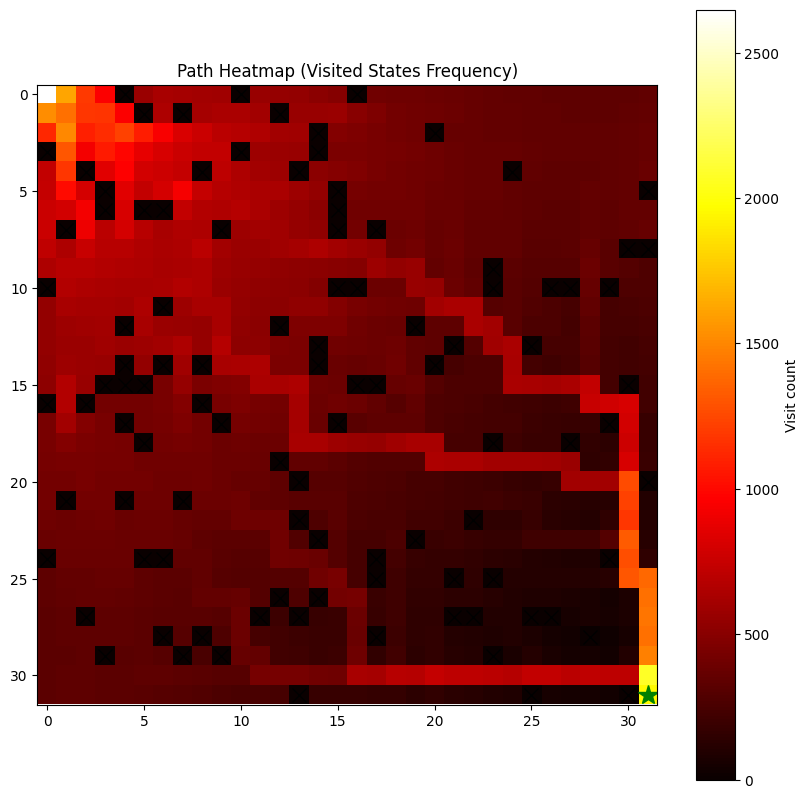


Best path length: 62

Final Q-values for key states:

State (0, 0):
up: -90.74
down: -90.69
left: -91.14
right: -90.69

State (15, 15):
up: -30.95
down: -30.08
left: -30.18
right: -21.71

State (31, 31):
up: 0.00
down: 0.00
left: 0.00
right: 0.00


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

class TreasureHunt:
    def __init__(self, grid_size=(32, 32), treasure_location=(31, 31), initial_state=(0, 0), obstacles=None):
        self.grid_size = grid_size
        self.treasure_location = treasure_location
        self.init_state = initial_state

        if obstacles is None:
            num_obstacles = int(0.1 * grid_size[0] * grid_size[1])
            self.obstacles = set()
            while len(self.obstacles) < num_obstacles:
                x = random.randint(0, grid_size[0]-1)
                y = random.randint(0, grid_size[1]-1)
                if (x,y) != initial_state and (x,y) != treasure_location:
                    self.obstacles.add((x,y))
        else:
            self.obstacles = set(obstacles)

        self.gamma = 0.95
        self.actions = ['up', 'down', 'left', 'right']
        self.states = [(x,y) for x in range(grid_size[0])
                           for y in range(grid_size[1])
                           if (x,y) not in self.obstacles]

    def get_reward(self, state):
        if state == self.treasure_location:
            return 1000
        elif state in self.obstacles:
            return -100
        else:
            distance_to_goal = abs(state[0] - self.treasure_location[0]) + \
                             abs(state[1] - self.treasure_location[1])
            return -1 - (distance_to_goal * 0.1)

    def get_next_state(self, state, action):
        x, y = state

        if action == 'up':    y = max(0, y-1)
        if action == 'down':  y = min(self.grid_size[1]-1, y+1)
        if action == 'left':  x = max(0, x-1)
        if action == 'right': x = min(self.grid_size[0]-1, x+1)

        next_state = (x,y)
        if next_state in self.obstacles:
            next_state = state

        return next_state

    def is_terminal(self, state):
        return state == self.treasure_location

class QLearningAgent:
    def __init__(self, env, alpha=0.1, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.q_table = defaultdict(float)
        self.best_path = None
        self.best_path_length = float('inf')

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.env.actions)
        else:
            return max(self.env.actions,
                      key=lambda a: self.q_table[(state, a)])

    def learn(self, num_episodes):
        rewards_per_episode = []
        steps_per_episode = []
        paths = []

        for episode in range(num_episodes):
            state = self.env.init_state
            total_reward = 0
            steps = 0
            current_path = [state]

            while not self.env.is_terminal(state):
                action = self.choose_action(state)
                next_state = self.env.get_next_state(state, action)
                reward = self.env.get_reward(next_state)

                old_value = self.q_table[(state, action)]
                next_max = max([self.q_table[(next_state, a)]
                              for a in self.env.actions])

                new_value = (1 - self.alpha) * old_value + \
                           self.alpha * (reward + self.env.gamma * next_max)

                self.q_table[(state, action)] = new_value

                state = next_state
                current_path.append(state)
                total_reward += reward
                steps += 1

                if steps > 1000:
                    break

            if self.env.is_terminal(state) and steps < self.best_path_length:
                self.best_path = current_path
                self.best_path_length = steps

            rewards_per_episode.append(total_reward)
            steps_per_episode.append(steps)
            paths.append(current_path)

            self.epsilon = max(0.01, self.epsilon * 0.999)

        return rewards_per_episode, steps_per_episode, paths

    def get_policy(self):
        policy = {}
        for state in self.env.states:
            policy[state] = max(self.env.actions,
                              key=lambda a: self.q_table[(state, a)])
        return policy

def plot_training_metrics(rewards, steps):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    window_size = 50
    rewards_smooth = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    steps_smooth = np.convolve(steps, np.ones(window_size)/window_size, mode='valid')

    ax1.plot(rewards_smooth)
    ax1.set_title('Training Progress - Rewards (Moving Average)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.grid(True)

    ax2.plot(steps_smooth)
    ax2.set_title('Training Progress - Steps (Moving Average)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps per Episode')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def visualize_policy_and_path(env, policy, best_path=None):
    """Create grid visualization of the learned policy and best path"""
    grid = np.full(env.grid_size, '.')


    for obstacle in env.obstacles:
        grid[obstacle] = 'X'


    grid[env.treasure_location] = 'T'


    arrow_map = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
    for state, action in policy.items():
        if state != env.treasure_location:
            grid[state] = arrow_map[action]


    if best_path:
        for i, pos in enumerate(best_path):
            if pos != env.treasure_location:
                grid[pos] = str(i % 10)


    print("\nLearned Policy and Path:")
    print(f"Best path length: {len(best_path) if best_path else 'N/A'} steps")
    chunk_size = 16
    for i in range(0, env.grid_size[0], chunk_size):
        for j in range(0, env.grid_size[1], chunk_size):
            print(f"\nChunk ({i},{j}) to ({min(i+chunk_size-1, env.grid_size[0]-1)},{min(j+chunk_size-1, env.grid_size[1]-1)}):")
            for row in grid[i:i+chunk_size, j:j+chunk_size]:
                print(' '.join(row))

def visualize_path_heatmap(env, paths):
    """Create a heatmap showing frequency of visited states"""
    visit_count = np.zeros(env.grid_size)

    for path in paths:
        for state in path:
            visit_count[state] += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(visit_count, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Visit count')
    plt.title('Path Heatmap (Visited States Frequency)')


    for obstacle in env.obstacles:
        plt.plot(obstacle[1], obstacle[0], 'kx', markersize=10)
    plt.plot(env.treasure_location[1], env.treasure_location[0], 'g*', markersize=15)

    plt.show()

def run_experiment():
    random.seed(42)
    env = TreasureHunt()

    agent = QLearningAgent(env, alpha=0.1, epsilon=0.2)
    rewards, steps, paths = agent.learn(num_episodes=2000)

    plot_training_metrics(rewards, steps)

    policy = agent.get_policy()
    visualize_policy_and_path(env, policy, agent.best_path)

    visualize_path_heatmap(env, paths)

    print("\nBest path length:", agent.best_path_length)
    print("\nFinal Q-values for key states:")
    key_states = [(0,0), (15,15), (31,31)]
    for state in key_states:
        if state not in env.obstacles:
            print(f"\nState {state}:")
            for action in env.actions:
                q_value = agent.q_table[(state, action)]
                print(f"{action}: {q_value:.2f}")

if __name__ == "__main__":
    run_experiment()